In [1]:
import os
import sys
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import cv2
from torch.utils.data import DataLoader
from skimage import io
import pandas as pd
import matplotlib.pyplot as plt
import math
import copy
import time
import PIL
import pickle

In [4]:
def load_train_data(class_num):
    # TODO : set 'class_path' with your train_data path.
    class_path  = f'./train_data/'
    x_data_path = class_path + 'x_data_' + str(class_num+1) + '.npy'
    y_data_path = class_path + 'y_data_' + str(class_num+1) + '.npy'
    x_data      = np.load(x_data_path, allow_pickle=True)
    y_data      = np.load(y_data_path, allow_pickle=True)
    return x_data, y_data

def load_valid_data(class_num):
    # TODO : set 'class_path' with your valid_data path.
    class_path  = f'./valid_data/'
    x_data_path = class_path + 'x_data_' + str(class_num+1) + '.npy'
    y_data_path = class_path + 'y_data_' + str(class_num+1) + '.npy'
    x_data      = np.load(x_data_path, allow_pickle=True)
    y_data      = np.load(y_data_path, allow_pickle=True)

    # return processed data. 
    return x_data, y_data

In [5]:
noisy_x_train, _ = load_train_data(0)
temp, _ = load_valid_data(0) 
noisy_x_train = np.concatenate((noisy_x_train, temp), axis=0);

In [6]:
for index in range(9):
    temp, _ = load_train_data(index+1)
    noisy_x_train = np.concatenate((noisy_x_train, temp), axis=0);
    temp, _ = load_valid_data(index+1)
    noisy_x_train = np.concatenate((noisy_x_train, temp), axis=0);

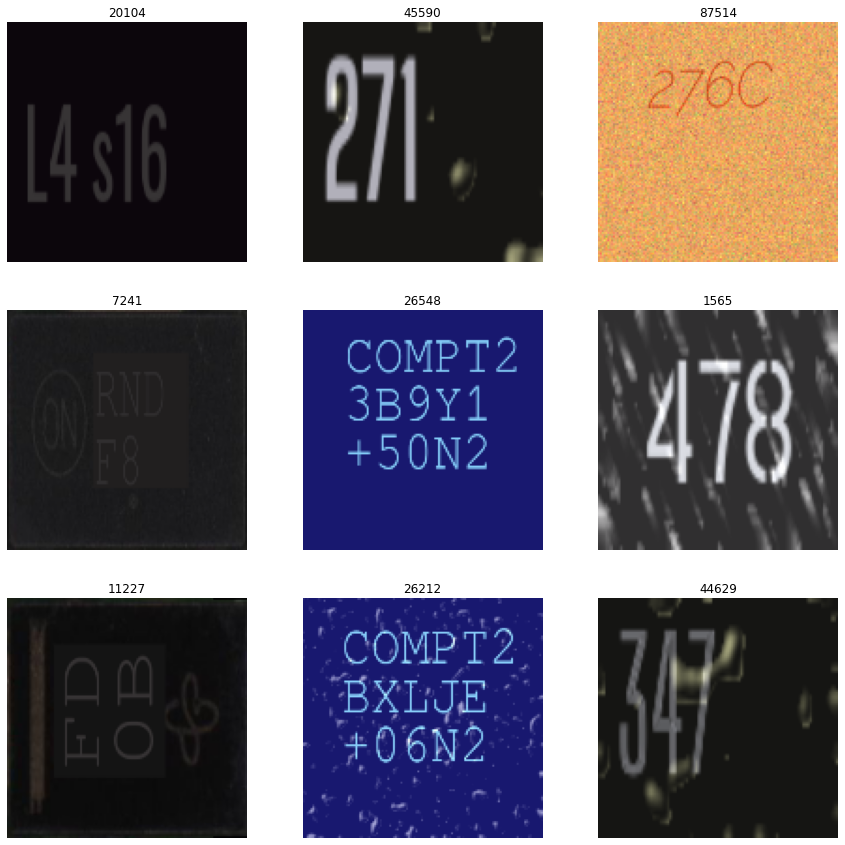

In [88]:
j = 0
image_number = np.random.randint(100000, size=9)
plt.figure(figsize=(15, 15))
for i in image_number:
    ax = plt.subplot(3, 3, j + 1)
    plt.imshow(noisy_x_train[i])
    plt.title(str(i))
    plt.axis("off")
    j+=1

In [275]:
from torch.optim import Adam

In [295]:
class Network_model(nn.Module):
    def __init__(self):
        super(Network_model, self).__init__()
        
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 6, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(6, 9, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(9, 12, 3, stride=2, padding=1),
            nn.ReLU(True)
        )
        
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(12, 9, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(9, 6, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(6, 3, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
        )
    
    def forward(self, x):
        image_reshape = torch.reshape(x,(x.shape[0],x.shape[3],x.shape[1],x.shape[2]))
        
        encoder = self.encoder_cnn(image_reshape)
        decoder = self.decoder_conv(encoder)
        
        image_denoising = torch.reshape(decoder,(x.shape[0],x.shape[1], x.shape[2],x.shape[3]))
        
        return image_denoising

In [296]:
class Denoising_trainer:
    def __init__(self, lr, batch_size):
        self.lr = lr
        self.batch_size = batch_size
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.network_model = Network_model().to(self.device)
        self.optimizer_network_model = Adam(self.network_model.parameters(), lr=self.lr)
        self.mse = nn.MSELoss()
        self.loss = 0
    
    def save_model(self):
        model_scripted = torch.jit.script(self.network_model)
        model_scripted.save('model/denoising.pt')
    
    def load_model(self):
        self.network_play = torch.jit.load('model/denoising.pt').to(self.device)
    
    def play(self, noisy_image):
        x_play_torch = torch.from_numpy(noisy_image).to(self.device).float()
        denoising_image = self.network_play(x_play_torch)
        return denoising_image
        
    def sampling_data(self, image_dataset):
        sampling_index = np.random.randint(image_dataset.shape[0], size=self.batch_size)
        train_batch=np.ndarray(shape=(self.batch_size,image_dataset.shape[1],image_dataset.shape[2],image_dataset.shape[3]), dtype=int)
        k=0
        for j in sampling_index:
            train_batch[k] = image_dataset[j]
            k+=1
        return train_batch
    
    def train(self, image_dataset):
        x_train = self.sampling_data(image_dataset)
        x_train_torch = torch.from_numpy(x_train).to(self.device).float()
        x_estimate = self.network_model(x_train_torch)
            
        loss_noise = self.mse(x_estimate, x_train_torch) 
        loss = loss_noise.item()  
        
        self.optimizer_network_model.zero_grad()
        loss_noise.backward()
        self.optimizer_network_model.step()
            
        self.save_model()
        
        return loss

In [297]:
haha = Denoising_trainer(lr=0.0003, batch_size=100)

In [298]:
for i in range(100):
    loss = haha.train(noisy_x_train)
    print(i, loss)

0 5010.7841796875
1 4511.4208984375
2 5869.13623046875
3 6793.96240234375
4 8194.44921875
5 8981.68359375
6 6256.015625
7 5363.828125
8 5523.70654296875
9 5078.240234375
10 8334.482421875
11 5575.89990234375
12 5797.267578125
13 8131.958984375
14 5392.89599609375
15 7305.58349609375
16 7559.49560546875
17 7659.97900390625
18 6302.20068359375
19 7956.19677734375
20 6193.80615234375
21 6110.79248046875
22 6362.8173828125
23 8312.21484375
24 6158.36474609375
25 6752.65966796875
26 8429.560546875
27 5247.29541015625
28 6321.021484375
29 5794.0693359375
30 6119.30908203125
31 5594.8525390625
32 6348.404296875
33 7287.625
34 8751.7333984375
35 5352.80859375
36 6487.34228515625
37 6918.4609375
38 6778.68896484375
39 6187.2314453125
40 7811.4189453125
41 5021.40087890625
42 7255.306640625
43 7849.32177734375
44 6934.14990234375
45 6285.9072265625
46 4660.482421875
47 6492.18310546875
48 6161.54736328125
49 6715.28076171875
50 4665.703125
51 8897.7978515625
52 7430.333984375
53 7008.24072265625

In [299]:
k = 0
test_number = 10
haha.load_model()
image_number = np.random.randint(noisy_x_train.shape[0], size=test_number)
test_batch = np.ndarray(shape=(test_number,noisy_x_train.shape[1],noisy_x_train.shape[2],noisy_x_train.shape[3]), dtype=int)
for i in image_number:
    test_batch[k] = noisy_x_train[i]
    k+=1

denoising_image = haha.play(test_batch)
print(denoising_image.shape)

torch.Size([10, 128, 128, 3])


In [302]:
denoising_image.max()

tensor(393.5192, grad_fn=<MaxBackward1>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


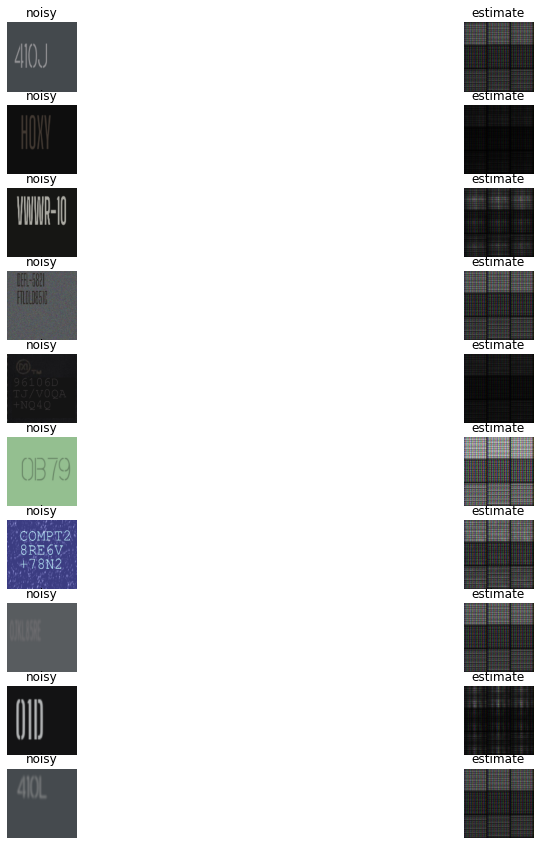

In [303]:
plt.figure(figsize=(15, 15))
for i in range(test_number):
    ax = plt.subplot(10, 2, i*2+1)
    plt.imshow(test_batch[i])
    plt.title("noisy")
    plt.axis("off")
    ax = plt.subplot(10, 2, i*2+2)
    plt.imshow(denoising_image[i].detach().numpy().astype(int))
    plt.title("estimate")
    plt.axis("off")